In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from pathlib import Path
train_path = Path('/kaggle/working/resized_train_images')
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# eg. /kaggle/input/happywhale-images-256-by-256/resized_test_images/cd50701ae53ed8.jpg
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [10]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [11]:
train_dir = '/kaggle/input/happywhale-images-256-by-256/resized_train_images/'

In [12]:
train_ids = pd.read_csv('/kaggle/input/trainids/train.csv')

In [13]:
im_list = os.listdir(train_dir)

In [14]:
# Build dataframe for list of image paths
train_df = pd.DataFrame(im_list, columns=['image'])
train_df = train_df.merge(train_ids, on='image', how='left')
train_df["image_path"] = train_df["image"].apply(lambda x: train_dir + "/" + x)
train_df.head()

,image,species,individual_id,image_path
0,80b5373b87942b.jpg,humpback_whale,7c80cd6f69de,/kaggle/input/happywhale-images-256-by-256/res...
1,e113b51585c677.jpg,humpback_whale,d5b28257276e,/kaggle/input/happywhale-images-256-by-256/res...
2,94eb976e25416c.jpg,false_killer_whale,7355eee87d75,/kaggle/input/happywhale-images-256-by-256/res...
3,19a45862ab99cd.jpg,humpback_whale,f4c8d427271e,/kaggle/input/happywhale-images-256-by-256/res...
4,be9645065510e9.jpg,beluga,b64d181ae2e6,/kaggle/input/happywhale-images-256-by-256/res...


In [15]:
# Make a directory in the /working/ folder so that we can write the needed file structure
!mkdir /kaggle/working/resized_train_images
# Warning this is slow
!cp -R /kaggle/input/happywhale-images-256-by-256/resized_train_images /kaggle/working/

In [16]:
def make_folders(path):
    """
    This function creates separate folders for each unique id,
    which will have 1 or more images per folder
    """
    mappings = train_df.groupby('individual_id')['image'].apply(list).to_dict()
    for folder, file_list in mappings.items():
        for imfile in file_list:
            imfile = Path(path.joinpath(imfile))
            Path(path.joinpath(folder)).mkdir(parents=True, exist_ok=True)
            path = Path(path.joinpath())
            try:
                imfile.rename(path / folder / imfile.name)
            except FileNotFoundError:
                print(f"Couldn't find {imfile.stem} in source folder")

In [17]:
train_dir = '/kaggle/working/resized_train_images/'


In [18]:
train_path = Path(train_dir)
make_folders(train_path)

In [19]:
import keras
from keras.utils import load_img, img_to_array,image_dataset_from_directory
import matplotlib.pyplot as plt

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout

# Transfer learning code

In [21]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [22]:
# folder path
# dir_path = 'resized_train_images'
from os import walk
# list to store files name
im_list = []
for (train_path, dir_names, file_names) in walk(train_path):
    im_list.extend(file_names)

In [23]:
train_dir = '/kaggle/working/resized_train_images'

In [31]:
def make_gens(px, bs):
    train_datagen = ImageDataGenerator(
                                    preprocessing_function=preprocess_input_vgg,
                                    rescale=1./255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True,
                                       validation_split=0.2)  # val 20%
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.2)


    train_data = train_datagen.flow_from_directory(train_dir, 
                                                   target_size=(px, px), 
                                                #    color_mode='rgb',
                                                   batch_size=bs, 
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset = 'training') 

    val_data = test_datagen.flow_from_directory(train_dir, 
                                               target_size=(px, px), 
                                            #    color_mode='rgb',
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset = 'validation')
    return (train_data, val_data)

In [32]:
train_data2, val_data2 = make_gens(128,200)

Found 45535 images belonging to 15587 classes.
Found 5498 images belonging to 15587 classes.


In [33]:
conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=(128,128,3))

In [38]:
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
# top_model = Dense(4096, activation='relu')(top_model)
# top_model = Dense(1072, activation='relu')(top_model)
# top_model = Dropout(0.5)(top_model)
output_layer = Dense(15587, activation='softmax')(top_model)

In [39]:
model3 = Model(inputs=conv_base.input, outputs=output_layer)

In [40]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
bs = 32
history = model3.fit(
        train_data2,
        # steps_per_epoch=16,
        # steps_per_epoch=2000 // 
        batch_size=bs,
        epochs=10
        ,validation_data=val_data2
#         ,steps_per_epoch=1400,
#          validation_steps=170
        )

Epoch 1/10
228/228 [==============================] - 313s 1s/step - loss: 8.6497 - accuracy: 0.0090 - val_loss: 6.8623 - val_accuracy: 0.0193
Epoch 2/10
228/228 [==============================] - 311s 1s/step - loss: 7.8782 - accuracy: 0.0123 - val_loss: 6.7511 - val_accuracy: 0.0204
Epoch 3/10
228/228 [==============================] - 312s 1s/step - loss: 7.4773 - accuracy: 0.0154 - val_loss: 6.3424 - val_accuracy: 0.0227
Epoch 4/10
228/228 [==============================] - 308s 1s/step - loss: 7.1398 - accuracy: 0.0175 - val_loss: 6.4995 - val_accuracy: 0.0151
Epoch 5/10
228/228 [==============================] - 319s 1s/step - loss: 6.8275 - accuracy: 0.0216 - val_loss: 6.7628 - val_accuracy: 0.0144
Epoch 6/10
228/228 [==============================] - 319s 1s/step - loss: 6.5456 - accuracy: 0.0251 - val_loss: 6.9176 - val_accuracy: 0.0149
Epoch 7/10
228/228 [==============================] - 313s 1s/step - loss: 6.2669 - accuracy: 0.0289 - val_loss: 7.3442 - val_accuracy: 0.0085

In [ ]:
model3.save('/kaggle/working/model3_vgg.keras')

/tmp/ipykernel_29/216795228.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_loss, 'b', label='train accuracy',color="blue")
/tmp/ipykernel_29/216795228.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_loss, 'b', label='test accuracy',color="red")


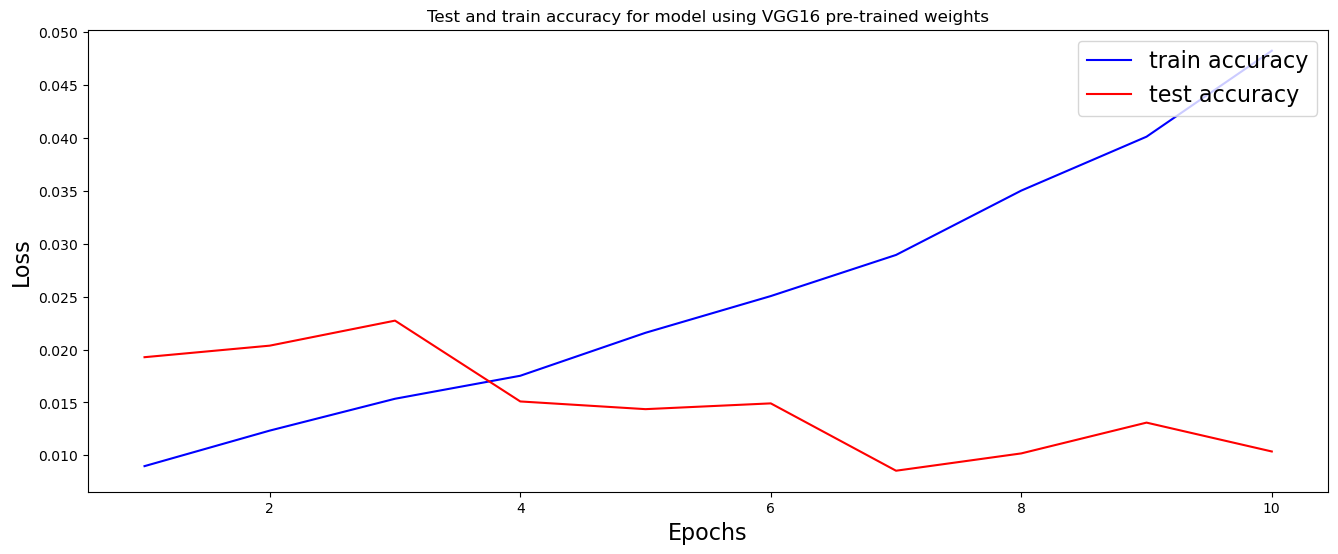

In [45]:
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']
nepochs=10
plt.figure(figsize=(16,6))
plt.plot(range(1,nepochs+1), train_loss, 'b', label='train accuracy',color="blue")
plt.plot(range(1,nepochs+1), test_loss, 'b', label='test accuracy',color="red")

#plt.ylim((0, 0.0001))
# plt.title('CNN: max(val_acc) = ' + str(round(max(test_acc),6)),fontsize=16)
# plt.title('CNN: max(val_acc) = ' + str(round(max(test_acc),6)),fontsize=16)
plt.title('Test and train accuracy for model using VGG16 pre-trained weights')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
# plt.ylim(0,0.06)

plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [ ]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
#### Try ArcFace loss
#### Try bounding boxes https://blog.roboflow.com/how-to-draw-a-bounding-box-in-python/
#### Try adding convolutional layer first? https://stackoverflow.com/questions/51845405/adding-conv-layer-in-front-of-pretrained-model-gives-valueerror

In [ ]:
conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=(256,256,3))

In [ ]:
batch_images = next(iter(train_ds))[0]
for batch_images, batch_labels in train_ds:
    preprocessed_images = tf.keras.applications.vgg16.preprocess_input(batch_images)

# Individual Whale Model

In [ ]:
train_in, val_in = make_gens(128, 16)

In [ ]:
model_in = Sequential()

model_in.add(Conv2D(filters=32, kernel_size = (5,5), strides = (1, 1), input_shape = (128, 128, 3)))
model_in.add(BatchNormalization(axis = 3))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((2, 2)))

model_in.add(Conv2D(filters=64, kernel_size = (4, 4), strides = (1,1)))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((3, 3)))

model_in.add(Conv2D(filters=128, kernel_size = (3, 3), strides = (1,1)))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((2,2)))

model_in.add(Conv2D(filters=256, kernel_size = (2, 2), strides = (1,1)))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((2,2)))
model_in.add(Dropout(0.5))

# model_in.add(Conv2D(filters=300, kernel_size = (3, 3), strides = (1,1)))
# model_in.add(Activation('relu'))
# model_in.add(MaxPooling2D((2,2)))

model_in.add(Flatten())
# model_in.add(Dense(512, activation="relu"))
# model_in.add(Dropout(0.2))

model_in.add(Dense(15587, activation='softmax')) # Number of species

model_in.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_in.summary()

In [ ]:
rec_history = model_in.fit(
      train_in,
#       steps_per_epoch=100,
      epochs=200,
      validation_data=val_in
#       ,validation_steps=50
      )

In [ ]:
model_in.save('/kaggle/working/indi_model.keras')

In [ ]:
# maybe try this instead? https://pypi.org/project/split-folders/

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
download_file('indi_model.keras', 'out')
copy


In [ ]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='valid',input_shape=(128,128, 3)))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))

model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(alpha=0.01)))

model.add(Conv2D(filters=len(val_data.class_indices), kernel_size=(1,1), strides=(1,1), padding='valid'))
model.add(Activation('softmax'))
model.add(Flatten())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()